In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.0002
epochs = 10
latent_dim = 100
img_size = 28 * 28

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, img_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss functions and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        # Adversarial ground truths
        valid = Variable(torch.ones(imgs.size(0), 1))
        fake = Variable(torch.zeros(imgs.size(0), 1))

        # Configure input
        real_imgs = Variable(imgs.view(imgs.size(0), -1))

        # Train Generator
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(torch.randn(imgs.size(0), latent_dim))
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

    # Early stopping mechanism (you may need to adjust this based on your validation set)
    if epoch > 10 and g_loss.item() < 0.1:
        print("Early stopping as generator loss is sufficiently low.")
        break

# Generate and save some sample images
sample_size = 16
z = Variable(torch.randn(sample_size, latent_dim))
sample_images = generator(z).detach().numpy().reshape(-1, 1, 28, 28)

[Epoch 0/10] [D loss: 0.2081775963306427] [G loss: 1.5575426816940308]
[Epoch 1/10] [D loss: 0.5215150117874146] [G loss: 0.8040906190872192]
[Epoch 2/10] [D loss: 0.3839665651321411] [G loss: 1.187340497970581]
[Epoch 3/10] [D loss: 0.18206071853637695] [G loss: 1.6937730312347412]
[Epoch 4/10] [D loss: 0.7057164907455444] [G loss: 0.7852322459220886]
[Epoch 5/10] [D loss: 0.4322560429573059] [G loss: 1.3958690166473389]
[Epoch 6/10] [D loss: 0.4089878797531128] [G loss: 1.3829721212387085]
[Epoch 7/10] [D loss: 0.4972245693206787] [G loss: 1.3480286598205566]
[Epoch 8/10] [D loss: 0.6270954608917236] [G loss: 0.9504597187042236]
[Epoch 9/10] [D loss: 0.4183861017227173] [G loss: 1.2919996976852417]


In [8]:
# Save generated images
for i in range(sample_size):
    img_array = (sample_images[i][0] + 1) / 2.0  # Rescale values from [-1, 1] to [0, 1]
    img = transforms.ToPILImage()(img_array)
    
    # Convert to 'L' (grayscale) mode before saving
    img = img.convert('L')
    
    img.save(f"generated_image_{i}.png")


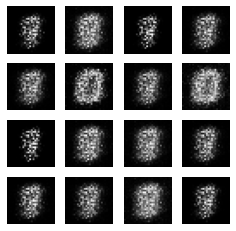

In [10]:
import matplotlib.pyplot as plt
# Save generated images using matplotlib
fig, axs = plt.subplots(4, 4, figsize=(4, 4))
cnt = 0
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(sample_images[cnt][0], cmap='gray')
        axs[i, j].axis('off')
        cnt += 1

plt.savefig("generated_images.png")
plt.show()
